# Vehicle Noise Classification (UK GOV dataset)

**Objective:** Predict whether a vehicle is **Quiet** or **Noisy** from engine and emission features in the UK Government fuel/emissions data.

## 1. Setup & Imports

Import core libraries and configure display options.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

pd.set_option('display.max_columns', None)
sns.set_theme()
print("Environment ready.")

Matplotlib is building the font cache; this may take a moment.


Environment ready.


## 2. Load Data

Automatically select the largest CSV in '/data' (typically the main vehicle table) and preview the schema.

In [12]:
base_dir = Path().resolve().parent
csv_path = base_dir / "data" / "Euro_6_latest.csv"

df = pd.read_csv(csv_path, low_memory=False, encoding='latin1')
print(df.shape)
df.info()
df.head(3)

(4197, 45)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4197 entries, 0 to 4196
Data columns (total 45 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Manufacturer                           4197 non-null   object 
 1   Model                                  4197 non-null   object 
 2   Description                            4197 non-null   object 
 3   Transmission                           3563 non-null   object 
 4   Manual or Automatic                    4197 non-null   object 
 5   Engine Capacity                        4195 non-null   float64
 6   Fuel Type                              4197 non-null   object 
 7   Powertrain                             4197 non-null   object 
 8   Engine Power (PS)                      4178 non-null   float64
 9   Engine Power (Kw)                      4189 non-null   float64
 10  Electric energy consumption Miles/kWh  2597 non-null   float6

,Manufacturer,Model,Description,Transmission,Manual or Automatic,Engine Capacity,Fuel Type,Powertrain,Engine Power (PS),Engine Power (Kw),Electric energy consumption Miles/kWh,wh/km,Maximum range (Km),Maximum range (Miles),Euro Standard,Diesel VED Supplement,Testing Scheme,WLTP Imperial Low,WLTP Imperial Medium,WLTP Imperial High,WLTP Imperial Extra High,WLTP Imperial Combined,WLTP Imperial Combined (Weighted),WLTP Metric Low,WLTP Metric Medium,WLTP Metric High,WLTP Metric Extra High,WLTP Metric Combined,WLTP Metric Combined (Weighted),WLTP CO2,WLTP CO2 Weighted,Equivalent All Electric Range Miles,Equivalent All Electric Range KM,Electric Range City Miles,Electric Range City Km,Emissions CO [mg/km],THC Emissions [mg/km],Emissions NOx [mg/km],THC + NOx Emissions [mg/km],Particulates [No.] [mg/km],RDE NOx Urban,RDE NOx Combined,Noise Level dB(A),Date of change,Unnamed: 44
0,ABARTH,500e MY25,114kW Electric (VL),A1,Electric - Not Applicable,0.0,Electricity,Battery Electric Vehicle (BEV) / Pure Electric...,155.0,114.0,3.6,172.0,264.0,164.0,Euro 6-WLTP (for BEVs only),False,WLTP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,223.0,359.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,68.0,07 October 2025,NaN
1,ABARTH,500e MY25,114kW Electric (VH),A1,Electric - Not Applicable,0.0,Electricity,Battery Electric Vehicle (BEV) / Pure Electric...,155.0,114.0,3.3,187.0,244.0,152.0,Euro 6-WLTP (for BEVs only),False,WLTP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,205.0,330.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,68.0,07 October 2025,NaN
2,ABARTH,500e MY25,114kW Electric Convertible (VL),A1,Electric - Not Applicable,0.0,Electricity,Battery Electric Vehicle (BEV) / Pure Electric...,155.0,114.0,3.6,172.0,264.0,164.0,Euro 6-WLTP (for BEVs only),False,WLTP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,223.0,359.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,68.0,07 October 2025,NaN


## 3. Normalise Column Names

Standardise headers to lowercase snake_case and map common variants to consistent names used later.

In [ ]:
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(r"[^\w]+", "_", regex=True)
)

rename_map = {
    "engine_capacity": "engine_cc",
    "fuel_type": "fuel_type",
    "transmission": "transmission",
    "manual_or_automatic": "gear_type",
    "wltp_co2": "co2_gkm",
    "wltp_metric_combined": "mpg_metric_combined",
    "wltp_imperial_combined": "mpg_imperial_combined",
    "emissions_nox_mg_km": "nox_mgkm",
    "manufacturer": "make",
    "model": "model",
}
for k, v in rename_map.items():
    if k in df.columns:
        df = df.rename(columns={k: v})

noise_candidates = [c for c in df.columns if ("noise" in c and "db" in c)]
if noise_candidates:
    df = df.rename(columns={noise_candidates[0]: "noise_db"})

cols_set = set(df.columns)
required = {"noise_db", "fuel_type", "engine_cc", "co2_gkm"}
missing = sorted(required - cols_set)
print("Missing required columns:", missing)

expected = {
    "make","model","engine_cc","fuel_type","transmission","gear_type",
    "co2_gkm","mpg_metric_combined","mpg_imperial_combined","noise_db","nox_mgkm"
}
print("Present (expected ∩ actual):", sorted(expected & cols_set))
print("Detected noise column candidates:", noise_candidates)

Missing required columns: []
Present (expected ∩ actual): ['co2_gkm', 'engine_cc', 'fuel_type', 'gear_type', 'make', 'model', 'mpg_imperial_combined', 'mpg_metric_combined', 'noise_db', 'transmission']
Detected noise column candidates: ['noise_level_db_a_']


## 4. Build Working Subset & Clean

Keep only the columns relevant to the noise classification task and ensure all numeric fields are valid.

In [21]:
keep_cols = [c for c in [
    "noise_db", "fuel_type", "engine_cc", "co2_gkm", "mpg_metric_combined", "mpg_imperial_combined", "gear_type", "transmission"
] if c in df.columns]

work = df[keep_cols].copy()

# Drop rows missing critical fields
work = work.dropna(subset=["noise_db", "fuel_type", "engine_cc", "co2_gkm"])

# Coerce numeric fields
for col in ["noise_db", "engine_cc", "co2_gkm", "mpg_metric_combined", "mpg_imperial_combined"]:
    if col in work.columns:
        work[col] = pd.to_numeric(work[col], errors="coerce")

# Drop any remaining NaNs after conversion
work = work.dropna()

print("shape after cleaning: ", work.shape)
display(work.describe(include="all").T.head(10))

shape after cleaning:  (3563, 8)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
noise_db,3563.0,NaN,NaN,NaN,55.382627,25.966766,0.0,65.0,67.0,68.0,77.0
fuel_type,3563,8,Petrol Electric,1215,NaN,NaN,NaN,NaN,NaN,NaN,NaN
engine_cc,3563.0,NaN,NaN,NaN,1689.610441,881.649969,0.0,1199.0,1499.0,1993.0,6749.0
co2_gkm,3563.0,NaN,NaN,NaN,127.484704,65.214456,0.0,114.0,132.0,152.0,453.0
mpg_metric_combined,3563.0,NaN,NaN,NaN,5.574712,2.980662,0.0,4.9,5.7,6.5,42.8
mpg_imperial_combined,3563.0,NaN,NaN,NaN,40.261325,18.589255,0.0,35.75,45.6,51.75,74.3
gear_type,3563,3,Automatic,2438,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transmission,3563,44,M6,567,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Clean invalid zeros & outliers (cleaning step)

In [22]:
clean = work.copy()

# Drop invalid zeros in key numeric columns
for col, min_valid in [
    ("noise_db", 60), # typical type-approved exterior pass-by noise -60-75 dB(A)
    ("engine_cc", 900), # <900cc unlikely in this table; anything below ~1L is typically jdm
    ("co2_gkm", 1), # 0 g/km would be EV; we are using engine metrics, so these are invalid
]:
    if col in clean.columns:
        clean = clean[clean[col] >= min_valid]

# Metric fuel: L/100km should be >0 and sensible (<25 L/100km is generous)
if "mpg_metric_combined" in clean.columns:
    clean = clean[(clean["mpg_metric_combined"] > 0) & (clean["mpg_metric_combined"] <25)]

# Imperial mpg: keep within plausible 10-100 mpg window
if "mpg_imperial_combined" in clean.columns:
    clean = clean[(clean["mpg_imperial_combined"] >= 10) & (clean["mpg_imperial_combined"] <= 100)]

print("Shape before: ", work.shape, "after: ", clean.shape)
display(clean.describe(include="all").T.loc[["noise_db","engine_cc","co2_gkm","mpg_metric_combined","mpg_imperial_combined"]].dropna(how="all"))

Shape before:  (3563, 8) after:  (2442, 8)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
noise_db,2442.0,NaN,NaN,NaN,67.620925,2.202018,63.0,66.0,67.0,69.0,77.0
engine_cc,2442.0,NaN,NaN,NaN,1848.282965,856.386267,998.0,1199.0,1598.0,1998.0,6749.0
co2_gkm,2442.0,NaN,NaN,NaN,150.865684,48.020189,33.0,123.0,140.0,160.0,453.0
mpg_metric_combined,2442.0,NaN,NaN,NaN,6.575143,2.170194,3.8,5.4,6.0,6.9,23.7
mpg_imperial_combined,2442.0,NaN,NaN,NaN,46.058804,10.662516,11.9,40.9,46.3,52.3,74.3


## 5. Create Target Label (Quiet vs Noisy)

Threshold noise_db at the dataset meedian to define a balanced binary class.

Noise threshold (median dB): 67.0
noise_class
Quiet    1264
Noisy    1178
Name: count, dtype: int64
noise_class
Quiet    0.518
Noisy    0.482
Name: proportion, dtype: float64


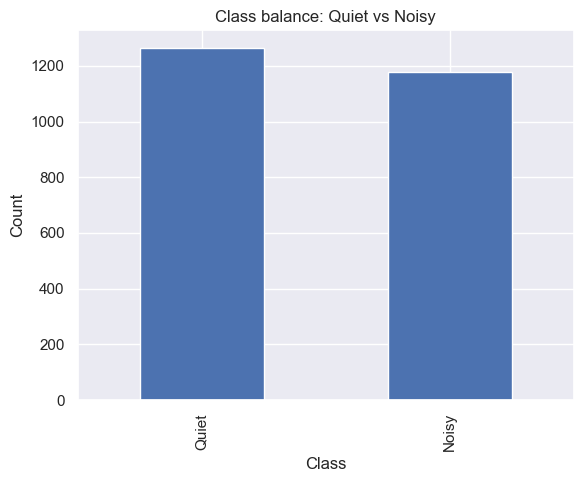

In [24]:
NOISE_THRESHOLD = float(clean["noise_db"].median())
print("Noise threshold (median dB):", NOISE_THRESHOLD)

clean = clean.copy()
clean["noise_class"] = np.where(clean["noise_db"] <= NOISE_THRESHOLD, "Quiet", "Noisy")

print(clean["noise_class"].value_counts())
print(clean["noise_class"].value_counts(normalize=True).round(3))

ax = clean["noise_class"].value_counts().plot(kind="bar", title="Class balance: Quiet vs Noisy")
ax.set_xlabel("Class"); ax.set_ylabel("Count")
plt.show()

## 6. Exploratory Data Analysis (EDA)

Explore distributions and relationships between features and the target ('Noise_Class') to understand which factors may influence vehicle noise.

### 6.1 Noise Distribution

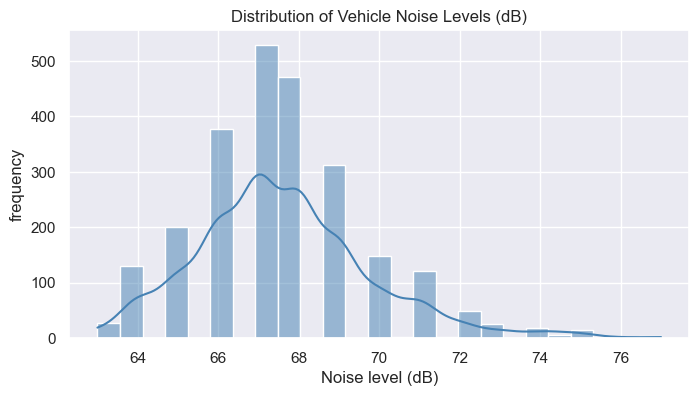

count    2442.000000
mean       67.620925
std         2.202018
min        63.000000
25%        66.000000
50%        67.000000
75%        69.000000
max        77.000000
Name: noise_db, dtype: float64


In [25]:
plt.figure(figsize=(8,4))
sns.histplot(clean["noise_db"], bins = 25, kde = True, color = "steelblue")
plt.title("Distribution of Vehicle Noise Levels (dB)")
plt.xlabel("Noise level (dB)")
plt.ylabel("frequency")
plt.show()

print(clean["noise_db"].describe())

The noise levels range rouhgly between 63-77 dB(A), with most vehicles clustered around 66-69 dB. This distribution is typical for Euro 6-certified vehicles and supports the median threshold chosen for classifying "Quiet" vs "Noisy".

### 6.2 Noise by Fuel Type

/var/folders/vv/zgms5s_n6s59blgyntzg0dgr0000gn/T/ipykernel_2166/3408860315.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clean, x="fuel_type", y="noise_db", palette="pastel")


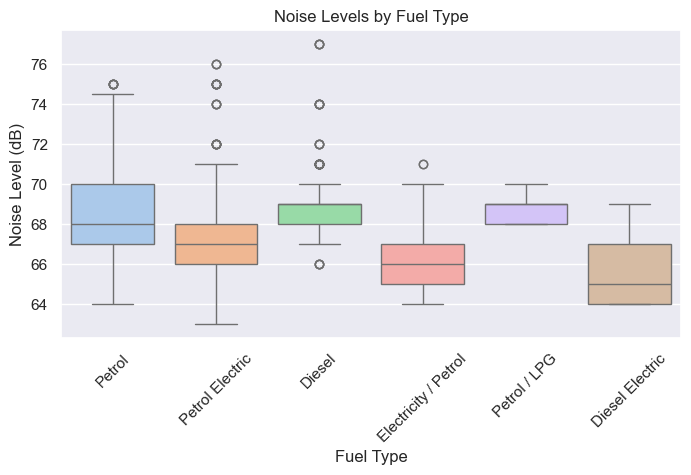

In [27]:
plt.figure(figsize=(8,4))
sns.boxplot(data=clean, x="fuel_type", y="noise_db", palette="pastel")
plt.title("Noise Levels by Fuel Type")
plt.xticks(rotation=45)
plt.xlabel("Fuel Type")
plt.ylabel("Noise Level (dB)")
plt.show()

Petrol and diesel vehicles show slightly higher median noise than hybrid or electric models, reflecting combustion noies differences. The variance also differs between fuel types, suggesting drivetrain design influences overall sound levels.

### 6.3 Noise vs Engine Capacity

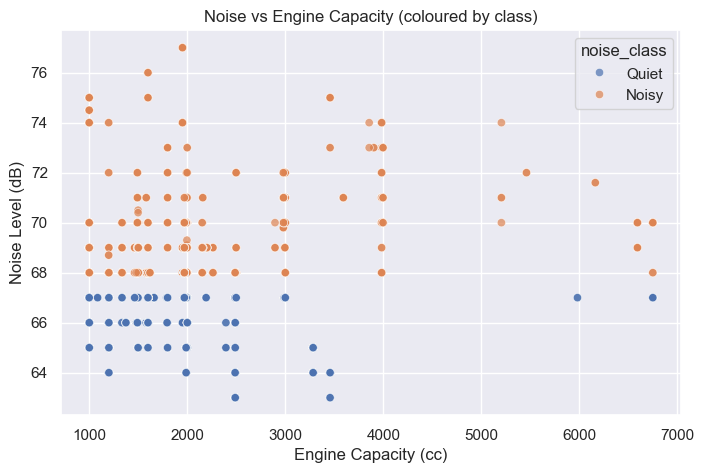

In [28]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=clean, x="engine_cc", y="noise_db", hue="noise_class", alpha=0.7)
plt.title("Noise vs Engine Capacity (coloured by class)")
plt.xlabel("Engine Capacity (cc)")
plt.ylabel("Noise Level (dB)")
plt.show()

There's a mild upward trend - larger engines tend to have higher noise levels, which is expected due to higher power output and mechanical load. The "Noisy" class clusters more towards high Engine capacities. 

### 6.4 Noise vs CO2 Emissions

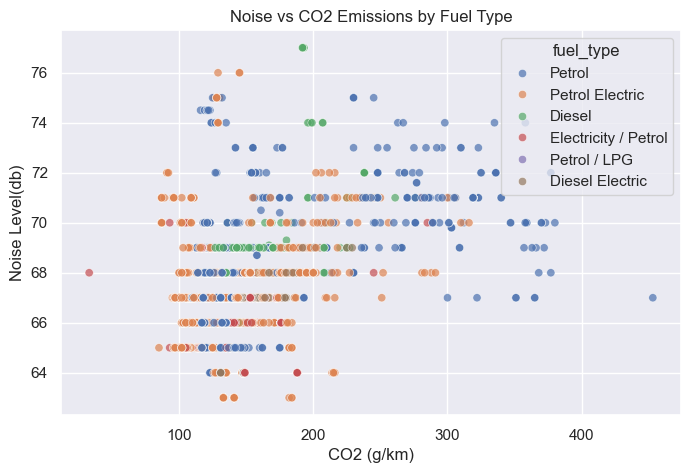

In [29]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=clean,x="co2_gkm", y="noise_db", hue="fuel_type", alpha=0.7)
plt.title("Noise vs CO2 Emissions by Fuel Type")
plt.xlabel("CO2 (g/km)")
plt.ylabel("Noise Level(db)")
plt.show()

Higher CO2 emissions loosely correlate with higher noise levels, likely because both are tied to engine size and efficiency. Hybrid vehicles are exceptions, with low emissions and moderate noise due to reduced combustion.

### 6.5 Correlation Heatmap

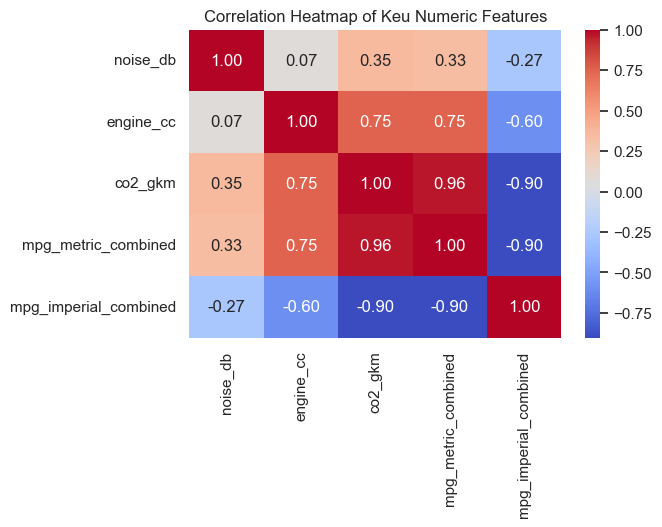

In [31]:
corr_features = ["noise_db", "engine_cc", "co2_gkm", "mpg_metric_combined", "mpg_imperial_combined"]
corr=clean[corr_features].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Keu Numeric Features")
plt.show()

Noise is positively correlated with engine capacuty and CO2 emissions, and inversely correlated with fuel efficiency (mpg). These insights justify including these variables in the classification model.

### 6.6 Class Distribution Summary

,engine_cc,co2_gkm,mpg_imperial_combined
noise_class,,,
Noisy,1864.3,165.7,43.3
Quiet,1833.4,137.1,48.6


/var/folders/vv/zgms5s_n6s59blgyntzg0dgr0000gn/T/ipykernel_2166/2168598934.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=clean, x="noise_class", palette="coolwarm")


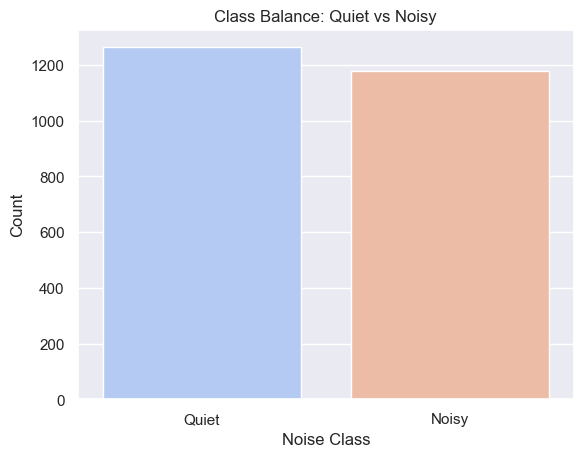

In [32]:
class_summary = clean.groupby("noise_class")[["engine_cc", "co2_gkm", "mpg_imperial_combined"]].mean().round(1)
display(class_summary)

sns.countplot(data=clean, x="noise_class", palette="coolwarm")
plt.title("Class Balance: Quiet vs Noisy")
plt.xlabel("Noise Class")
plt.ylabel("Count")
plt.show()

The class distribution is rouhgly balanced, confirming the median split worked well. On average, "Noisy" vehicles have higher engine capacity and CO2 emissions, while "Quiet" vehicles are more fuel-efficient.

## 7. Encode, Split, and Scale

Prepare data for machine learning by one-hot encoding categorical variables, splitting into training and test sets, and scaling numeric features for models that require it.

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

model_df = clean.copy()

# Encode categorical features
cat_cols = [c for c in ["fuel_type", "gear_type", "transmission"] if c in model_df.columns]
model_df = pd.get_dummies(model_df, columns=cat_cols, drop_first=True)

# Define features and target
X = model_df.drop(columns=["noise_db", "noise_class"])
y = model_df["noise_class"]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Identify numeric columns for scaling
num_cols = X_train.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()

# Scale numeric columns (for logistic regression)
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print("\nScaled numeric features:", list(num_cols)[:10])

Training set size: (1953, 47)
Testing set size: (489, 47)

Scaled numeric features: ['engine_cc', 'co2_gkm', 'mpg_metric_combined', 'mpg_imperial_combined']
